# setup and imports

In [193]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [194]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [195]:
rat_markers = {}
sequence = {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal',
                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'}

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}


# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatM00':
        rat_markers[animal][0] = 'orange'
        
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

 

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32


Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43
Loading data for RatM53
Loading data for RatM54


In [196]:
def round_nearest(x, a=0.04):
    return np.around(x / a) * a

def generate_idle_time(alpha, gamma, N=1, maximum=500):
    def p(x, a, g): 
        return a / np.sqrt(2 * np.pi * x ** 3) * np.exp(-((a-g * x) ** 2) / (2 * x))
    def normalization(x, a, g): 
        return simps(p(x, a, g), x)
    x = np.linspace(1e-8, maximum, maximum*100)

    pdf = p(x, alpha, gamma)/normalization(x, alpha, gamma)
    cdf = np.cumsum(pdf); cdf /= max(cdf)
    u = np.random.uniform(0, 1, int(N))
    interp_function = interp1d(cdf, x)
    samples = interp_function(u)
    return round_nearest(samples)

# Fig Drift

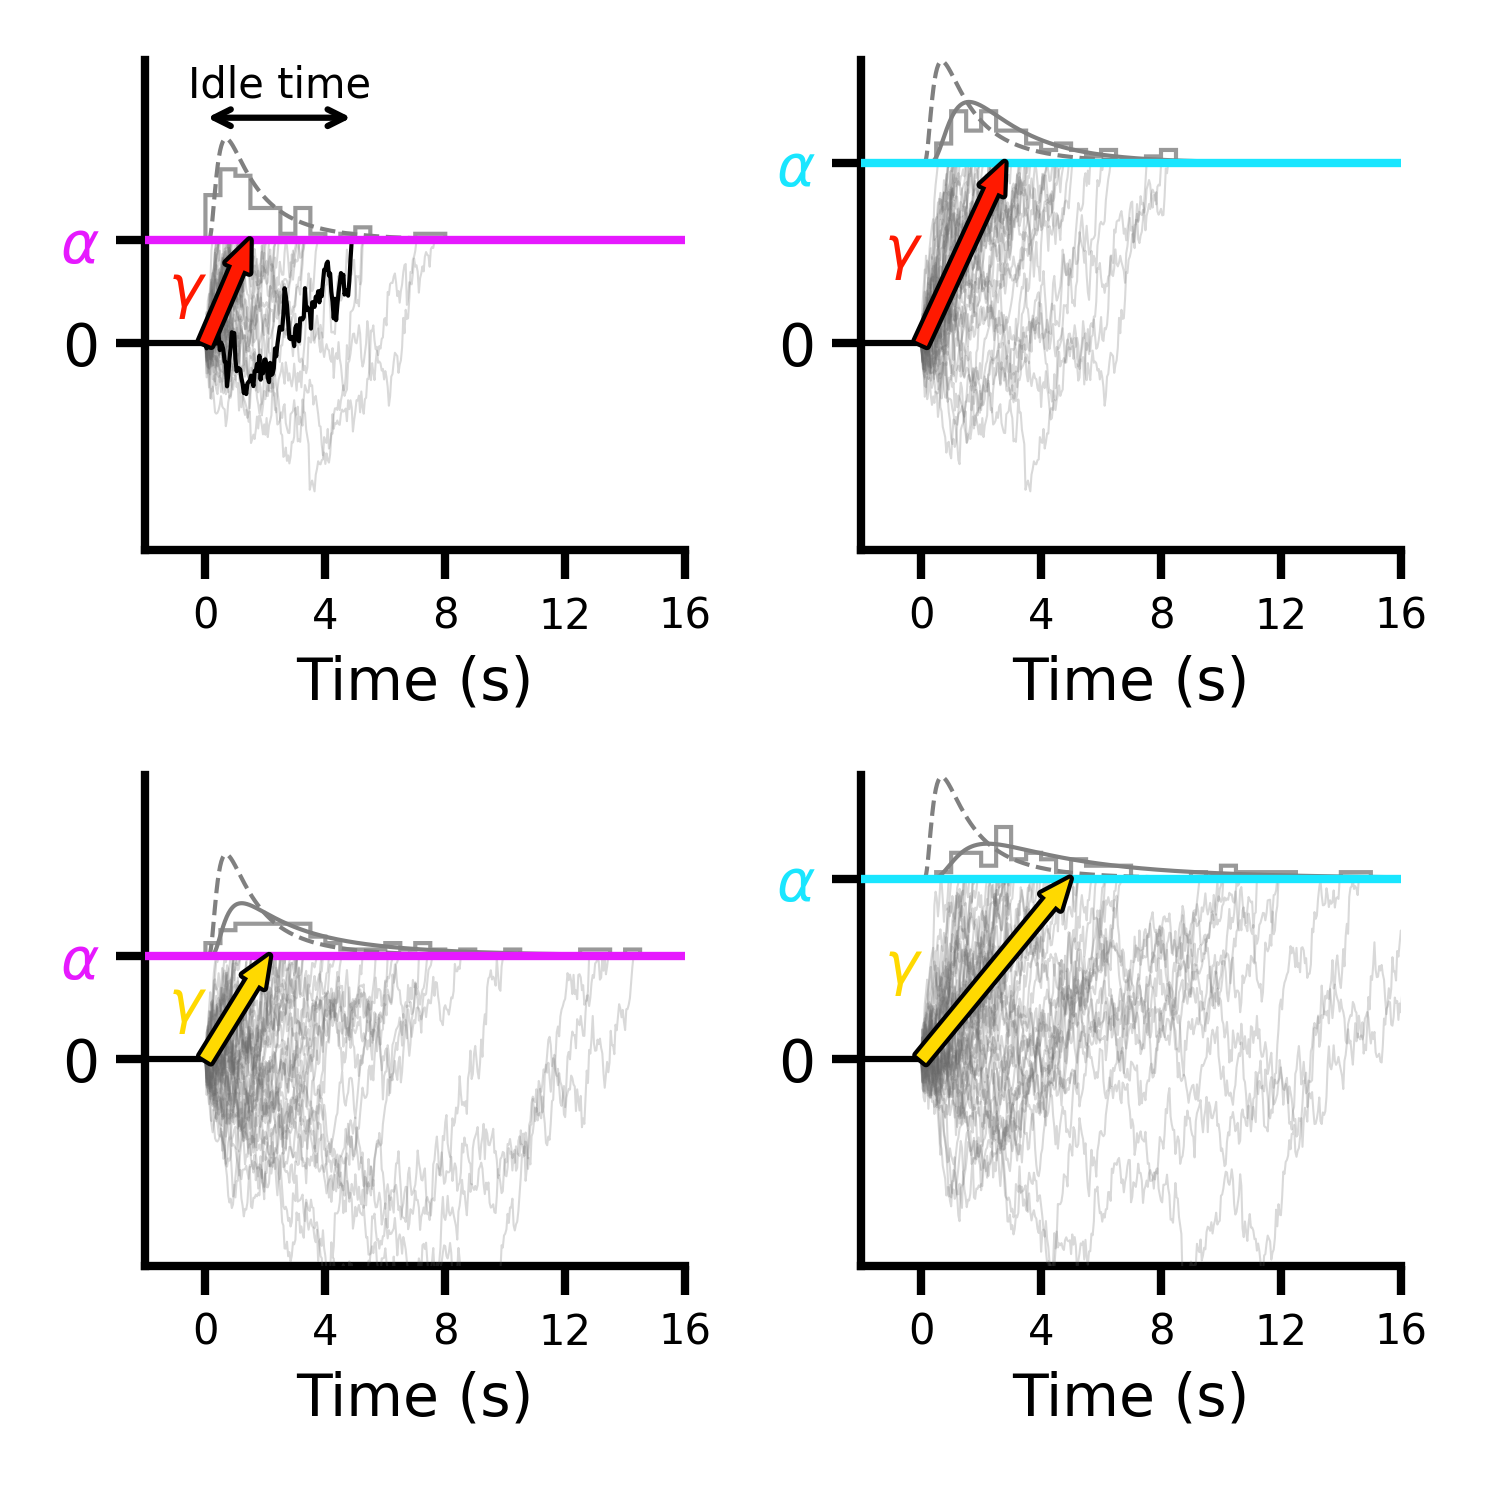

In [197]:
def Figure4_A(ax=None, mean=.2, std=1, A=10, t0=2, N=50, alphacolor='c', gammacolor='r', base=True, xx=None, yy=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    np.random.seed(51)
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv
        if base:
            if 4*25 <= len(y) < 5*25 and example_plot:
                ax.plot(x, y, c='k', lw=0.5, zorder=4)
                example_plot = False

                # idle time arrow
                ax.annotate(text='', xy=(-.5, 17.5), xytext=(len(y)/25+.5, 17.5), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
                ax.annotate(text='Idle time', xy=(0, 0), xytext=(len(y)/50, 20), ha='center', va='center',
                            xycoords='data', fontsize=5, zorder=5)
                
        ax.plot(x, y, c='dimgray', alpha=.25, zorder=3, lw=.25,)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c=alphacolor, zorder=5, lw=1)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$\alpha$'], fontsize=7)
    ax.get_yticklabels()[1].set_color(alphacolor)
    ax.set_xlabel('Time (s)')
    ax.set_ylim(-16, 22)
    ax.set_xlim(-2, 16)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=.75)
    # space_axes(ax)


    # gamma arrow
    # ax.text(waitmean/50-1, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    ax.text(-0.6, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    style = "Simple, head_width=.1, tail_width=0.05, head_length=.12"
    kw = dict(arrowstyle=style)
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0, edgecolor='k',
                                            mutation_scale=30, 
                                            lw=1, zorder=9, **kw))
    
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0,
                                            mutation_scale=30, 
                                            color=gammacolor, 
                                            lw=0, zorder=10, **kw))
    
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax.hist(waits, bins=bins, color='gray',
             alpha=.8, zorder=4, histtype="step", lw=.5,
             bottom=A,
             weights=np.ones_like(waits) / len(waits) *25,
             )
    
    p, _ = wald_fit(waits)
    x = np.linspace(0.01, 20, 1000)

    if base:
        ax.plot(x, A+Wald_pdf(x, *p)*15, 'gray', lw=.5, ls='--')
        return x, Wald_pdf(x, *p)*15
    else:
        ax.plot(x, A+Wald_pdf(x, *p)*15, 'gray', lw=.5)
        ax.plot(xx, A+yy, c='gray', lw=.5, ls='--')


fig, axs = plt.subplots(2, 2, figsize=(cm2inch(6), cm2inch(6)), dpi=600)
x, y = Figure4_A(ax=axs[0, 0], A=8, mean=.2, base=True, alphacolor=plt.get_cmap('cool_r')(0.1), 
                 gammacolor=plt.get_cmap('autumn')(0.1))

Figure4_A(ax=axs[0, 1], A=14, mean=.2, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), 
          gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
Figure4_A(ax=axs[1, 0], A=8, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.1), 
          gammacolor=plt.get_cmap('autumn')(0.85), xx=x, yy=y)
Figure4_A(ax=axs[1, 1], A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), 
          gammacolor=plt.get_cmap('autumn')(0.85), xx=x, yy=y)

# x, y, l, h = axs[0, 0].get_position().bounds
# print(x, y, l, h)
# plot_wald_overlay(w1, ax=fig.add_axes([x, y, l, h]))

# 4A $\alpha_0 \gamma_0$

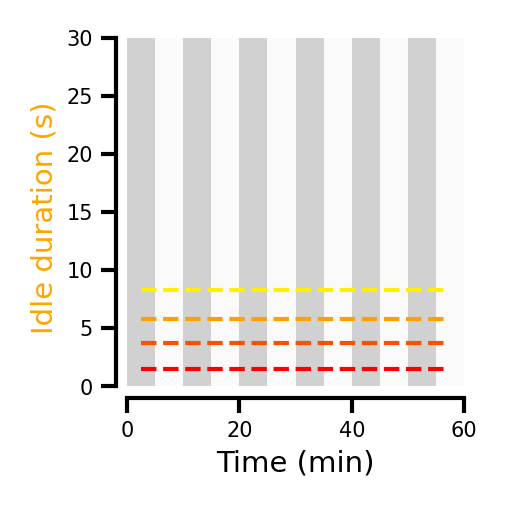

In [198]:
# plot variable median/mean fir each block
def Figure4A(ax=None, cmap=plt.get_cmap('autumn'), reverse=False, hide_xlabel=False):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75]
    modifs = [-1.25, 1, 3, 5.5]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif for i in range(0, len(blocks))],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    if not hide_xlabel:
        ax.set_xlabel("Time (min)")
    ax.set_ylabel("Idle duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4A(ax=ax)

# 4B  $\alpha_t \gamma_t$

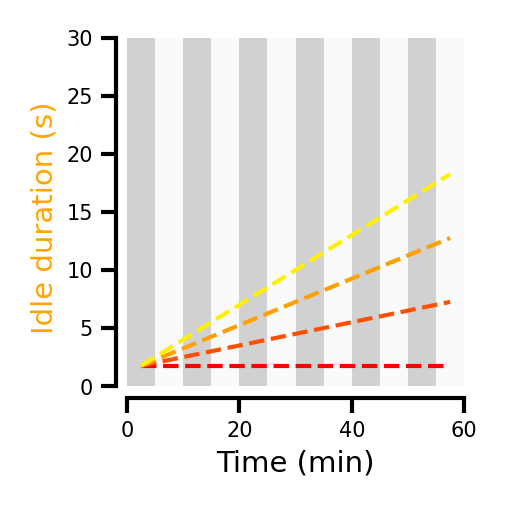

In [199]:
# plot variable median/mean fir each block
def Figure4B(ax=None, cmap=plt.get_cmap('autumn'), reverse=False, hide_xlabel=False):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [0, 0.5, 1, 1.5]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + (i*modif) for i in range(0, len(blocks))],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    if not hide_xlabel:
        ax.set_xlabel("Time (min)")
    ax.set_ylabel("Idle duration (s)", color='orange')
    ax.set_xticks([0, 20, 40, 60])
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4B(ax=ax)

# 4C  $\alpha_R \gamma_R$

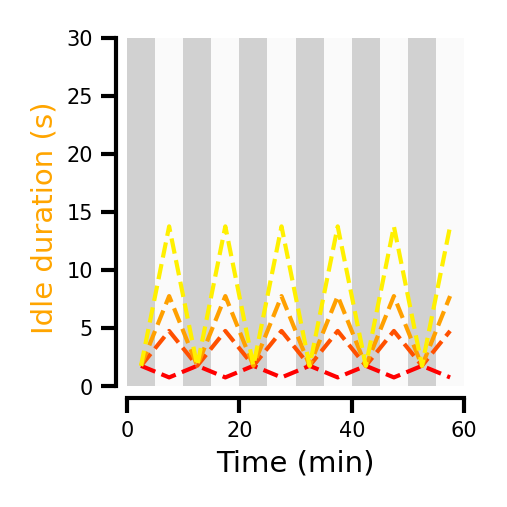

In [200]:
# plot variable median/mean fir each block
def Figure4C(ax=None, cmap=plt.get_cmap('autumn'), reverse=False, hide_xlabel=False):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [-1, 3, 6, 12]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif if i % 2 == 1 else dummy_data[i] for i in range(0, len(blocks)) ],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    if not hide_xlabel:
        ax.set_xlabel("Time (min)")
    ax.set_ylabel("Idle duration (s)", color='orange')
    ax.set_xticks([0, 20, 40, 60])
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4C(ax=ax)

/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: divide by zero encountered in true_divide
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))
/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: invalid value encountered in multiply
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))


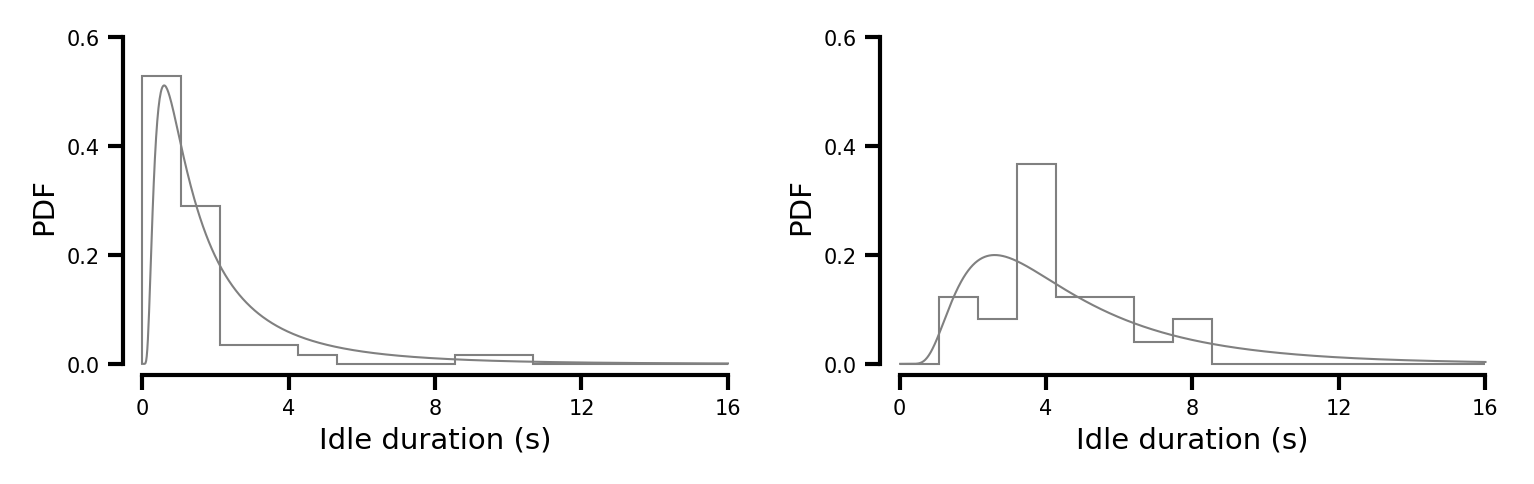

In [201]:

def plot_distribution_idle(ax=None, timebin=0, historybin=0):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    idletimes = prepare_data_idle_times(sequence, [animal], [session])
    idletimes = idletimes[animal][timebin][historybin]
    # idletimes = [item for sublist in prepare_data_idle_times(sequence, [animal], [session])[animal][i] for item in sublist]

    bins=np.linspace(0, 16, 16)
    ydata, xdata, _ = ax.hist(idletimes, bins=bins,
                    color='gray', zorder=10, lw=.5,
                    density=True,
                    weights=np.ones_like(idletimes) / len(idletimes),
                    histtype="step")
    
    x = np.linspace(0, 16, 1000)
    p, _ = wald_fit(idletimes)
    y = Wald_pdf(x, *p)
    ax.plot(x, y, zorder=4, lw=0.5, c='gray')

    ax.set_xlim(0, 16)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.set_ylim(0, .6)
    ax.set_yticks([0, .2, .4, .6])
    ax.set_xlabel('Idle duration (s)')
    ax.set_ylabel('PDF')


    # x_peak = x[np.argmax(y)]
    # y_peak = y[np.argmax(y)]

    # # mu arrow
    # ax.annotate(text='', xy=(x_peak, y_peak), xytext=(x_peak, y_peak+.04), arrowprops=dict(arrowstyle='->', lw=0.75), fontsize=5, zorder=5)
    # ax.annotate(text=r'$\mu$', xy=(x_peak, y_peak), xytext=(x_peak, y_peak+.05), ha='center', va='center',
    #             xycoords='data', fontsize=7, zorder=5)
    
    # half_max = np.max(y)/2
    # idx = np.argwhere(np.diff(np.sign(y - half_max))).flatten()
    # ax.annotate(text='', xy=(x[idx[0]], half_max), xytext=(x[idx[-1]], half_max), arrowprops=dict(arrowstyle='<->', lw=0.75, shrinkA=0, shrinkB=0), fontsize=5, zorder=5)
    # ax.annotate(text=r'$\sigma$', xy=(x_peak, y_peak/2), xytext=(x_peak, y_peak/2), ha='center', va='top',
    #             xycoords='data', fontsize=7, zorder=5)
    space_axes(ax)


fig, axs = plt.subplots(1, 2, figsize=(5, 1.5),)
plot_distribution_idle(axs[0], timebin=0, historybin=0)
plot_distribution_idle(axs[1], timebin=-1, historybin=0)



# 4D model + data

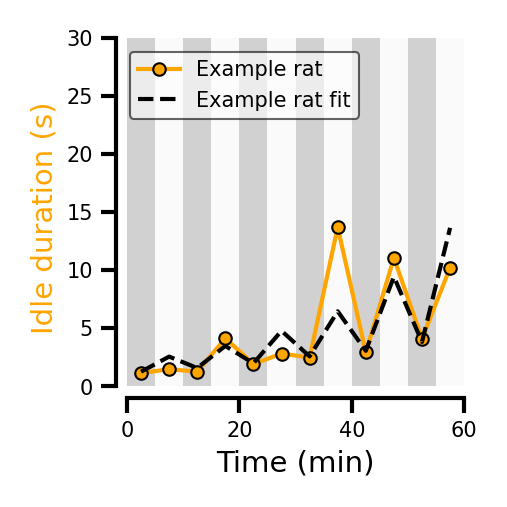

In [202]:
# plot variable median/mean fir each block
def Figure4D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
    # ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
    #         [dummy_data[i] for i in range(0, len(blocks))],  # or use median
    #         color='orange', 
    #         zorder=4, markeredgecolor='k', markeredgewidth=0.5,
    #         ls='--', label='Synthetic data')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Idle duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    # ax.set_yticks([0, 5, 10, 15])
    space_axes(ax)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],
            marker='o', ms=3, color='orange', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')



    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4
    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            ALPHA[bin, avg] = ex_alpha + bin*ex_alpha_t + avg*ex_alpha_R
            GAMMA[bin, avg] = ex_gamma + bin*ex_gamma_t + avg*ex_gamma_R

    a = []
    g = []
    for i in range(6):
        a.append(.9*ALPHA[i][0]+0.1*ALPHA[i][1])
        a.append(.9*ALPHA[i][-1]+0.1*ALPHA[i][-2])
        g.append(.9*GAMMA[i][0]+0.1*GAMMA[i][1])
        g.append(.9*GAMMA[i][-1]+0.1*GAMMA[i][-2])

    res = [np.median(generate_idle_time(a[i], g[i], 1000)) for i in range(12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [res[i] for i in range(0, len(blocks))],  # or use median
            color='k', ls='--', label='Example rat fit', zorder=5)


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4D(ax=ax)

# 4FGH fit result dist

p_value_60_90: 0.7954 p_value_60_120: 0.8915 p_value_90_120: 0.6598
p_value_60_90: 0.3457 p_value_60_120: 0.1247 p_value_90_120: 0.4753
p_value_60_90: 0.8787 p_value_60_120: 0.4477 p_value_90_120: 0.5067
p_value_60_90: 0.9702 p_value_60_120: 0.8566 p_value_90_120: 0.8386
p_value_60_90: 0.8618 p_value_60_120: 0.6783 p_value_90_120: 0.5319
p_value_60_90: 0.9532 p_value_60_120: 0.9301 p_value_90_120: 0.8518


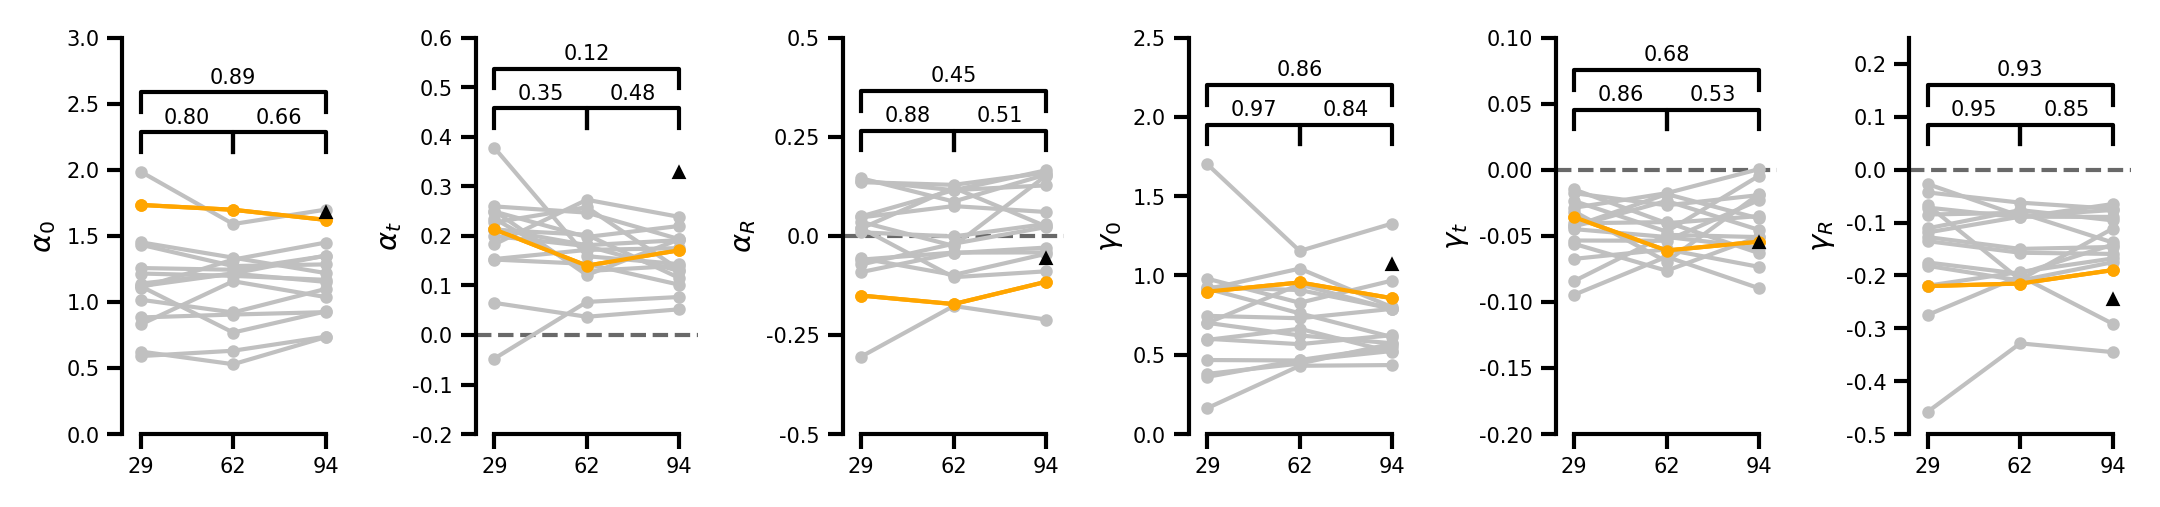

In [203]:
def Figure4F(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_0[animal]["60"], alpha_0[animal]["90"], alpha_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_0[animal]["60"], alpha_0[animal]["90"], alpha_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_distances(alpha_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)


def Figure4G(ax=None,show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_t[animal]["60"], alpha_t[animal]["90"], alpha_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_t[animal]["60"], alpha_t[animal]["90"], alpha_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.2, .6)
    ax.set_ylabel(r'$\alpha_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_distances(alpha_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)


def Figure4H(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_R[animal]["60"], alpha_R[animal]["90"], alpha_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=f'Individuals (n={len(animalList)})', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [alpha_R[animal]["60"], alpha_R[animal]["90"], alpha_R[animal]["120"]], 
                        color=rat_markers[animal][0], label='Example rat', marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_R, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, .5)
    ax.set_yticks([-0.5, -.25, 0, .25, 0.5])
    ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_R$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_distances(alpha_R, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)


def Figure4I(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_0[animal]["60"], gamma_0[animal]["90"], gamma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_0[animal]["60"], gamma_0[animal]["90"], gamma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 2.5)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_distances(gamma_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)


def Figure4J(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_t[animal]["60"], gamma_t[animal]["90"], gamma_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_t[animal]["60"], gamma_t[animal]["90"], gamma_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    

    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.2, .1)
    ax.set_ylabel(r'$\gamma_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_distances(gamma_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)


def Figure4K(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_R[animal]["60"], gamma_R[animal]["90"], gamma_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [gamma_R[animal]["60"], gamma_R[animal]["90"], gamma_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_R, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, 0.25)
    ax.set_ylabel(r'$\gamma_R$')
    
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_distances(gamma_R, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)


fig, axs = plt.subplots(1, 6, figsize=(cm2inch(18), cm2inch(4)))
Figure4F(axs[0])
Figure4G(axs[1])
Figure4H(axs[2])
Figure4I(axs[3])
Figure4J(axs[4])
Figure4K(axs[5])


# # This is a hack to get the legend to not mess up the spacing
# handles, labels = axs[0].get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# fig.legend(*zip(*unique), loc='upper center',# bbox_to_anchor=(0.01, 0.99), 
#                             frameon=False, fontsize=5, markerscale=1, 
#                             edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

p_value_20_0: 0.8682 p_value_0_rev20: 0.8537 p_value_20_rev20: 0.7258
p_value_20_0: 0.3627 p_value_0_rev20: 0.1638 p_value_20_rev20: 0.5745
p_value_20_0: 0.7218 p_value_0_rev20: 0.9243 p_value_20_rev20: 0.7886
p_value_20_0: 0.5759 p_value_0_rev20: 0.2768 p_value_20_rev20: 0.0926
p_value_20_0: 0.9245 p_value_0_rev20: 0.066 p_value_20_rev20: 0.0628
p_value_20_0: 0.894 p_value_0_rev20: 0.7596 p_value_20_rev20: 0.6363


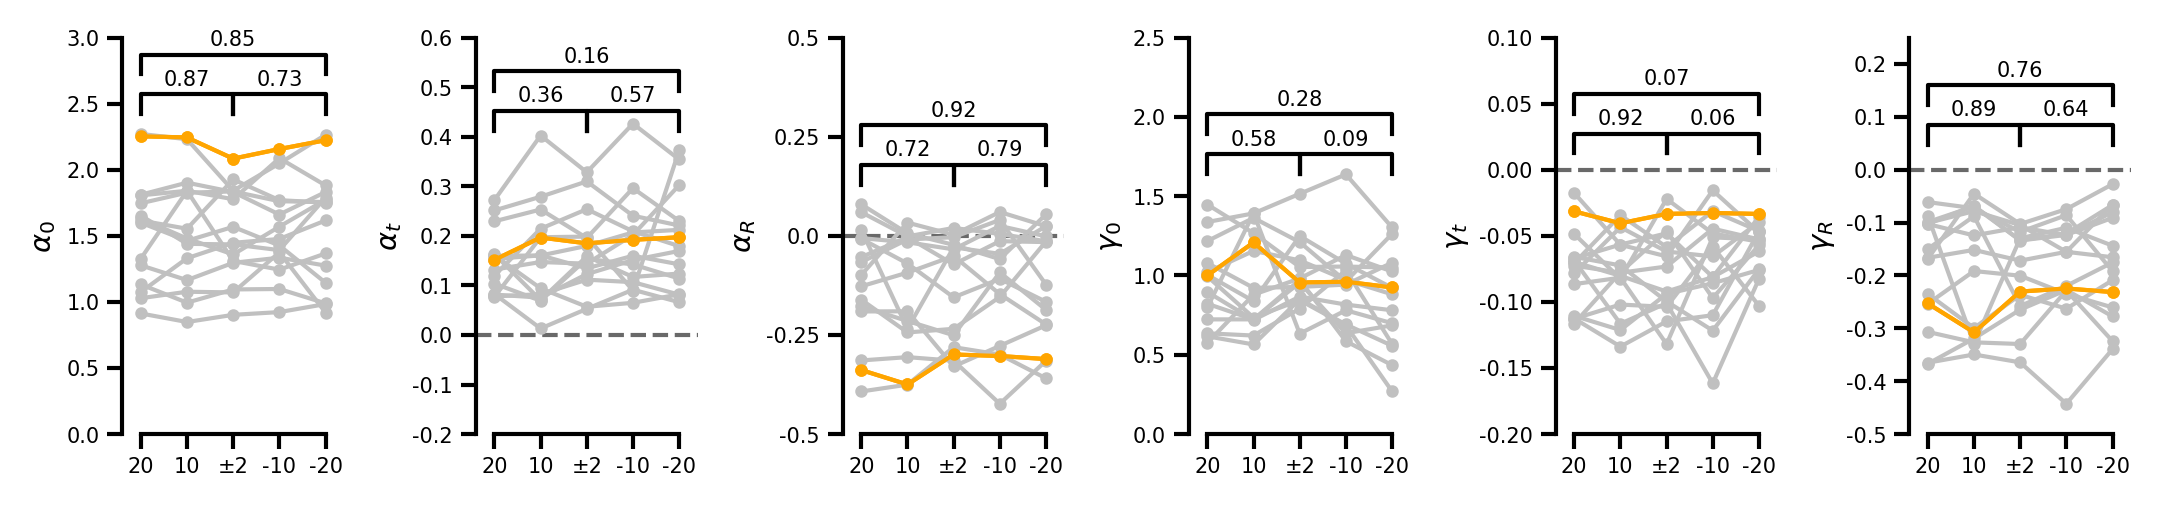

In [204]:
def Figure4L(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_0[animal]["20"], alpha_0[animal]["10"], alpha_0[animal]["2"], alpha_0[animal]["rev10"], alpha_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [alpha_0[animal]["20"], alpha_0[animal]["10"], alpha_0[animal]["2"], alpha_0[animal]["rev10"], alpha_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')

    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_vbelt(alpha_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)


def Figure4M(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_t[animal]["20"], alpha_t[animal]["10"], alpha_t[animal]["2"], alpha_t[animal]["rev10"], alpha_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [alpha_t[animal]["20"], alpha_t[animal]["10"], alpha_t[animal]["2"], alpha_t[animal]["rev10"], alpha_t[animal]["rev20"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.2, .6)
    ax.set_ylabel(r'$\alpha_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)

    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_vbelt(alpha_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)


def Figure4N(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_R[animal]["20"], alpha_R[animal]["10"], alpha_R[animal]["2"], alpha_R[animal]["rev10"], alpha_R[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [alpha_R[animal]["20"], alpha_R[animal]["10"], alpha_R[animal]["2"], alpha_R[animal]["rev10"], alpha_R[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([-0.5, -.25, 0, .25, 0.5])
    ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_R$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_vbelt(alpha_R, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)




def Figure4O(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_0[animal]["20"], gamma_0[animal]["10"], gamma_0[animal]["2"], gamma_0[animal]["rev10"], gamma_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [gamma_0[animal]["20"], gamma_0[animal]["10"], gamma_0[animal]["2"], gamma_0[animal]["rev10"], gamma_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 2.5)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_vbelt(gamma_0, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, num_permutations=10000)

def Figure4P(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_t[animal]["20"], gamma_t[animal]["10"], gamma_t[animal]["2"], gamma_t[animal]["rev10"], gamma_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [gamma_t[animal]["20"], gamma_t[animal]["10"], gamma_t[animal]["2"], gamma_t[animal]["rev10"], gamma_t[animal]["rev20"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.2, 0.1)
    ax.set_ylabel(r'$\gamma_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_vbelt(gamma_t, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)


def Figure4Q(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_R[animal]["20"], gamma_R[animal]["10"], gamma_R[animal]["2"], gamma_R[animal]["rev10"], gamma_R[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2, 3, 4], [gamma_R[animal]["20"], gamma_R[animal]["10"], gamma_R[animal]["2"], gamma_R[animal]["rev10"], gamma_R[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{belt}$'
    if show_xlabel:
        ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.5, 0.25)
    ax.set_ylabel(r'$\gamma_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    permutation_test_vbelt(gamma_R, ax=ax, h='top', dhs=[0.05, 0.15], barh=.05, shifty=0.05, num_permutations=10000)

fig, axs = plt.subplots(1, 6, figsize=(cm2inch(18), cm2inch(4)))
Figure4L(axs[0])
Figure4M(axs[1])
Figure4N(axs[2])
Figure4O(axs[3])
Figure4P(axs[4])
Figure4Q(axs[5])

# illustrations

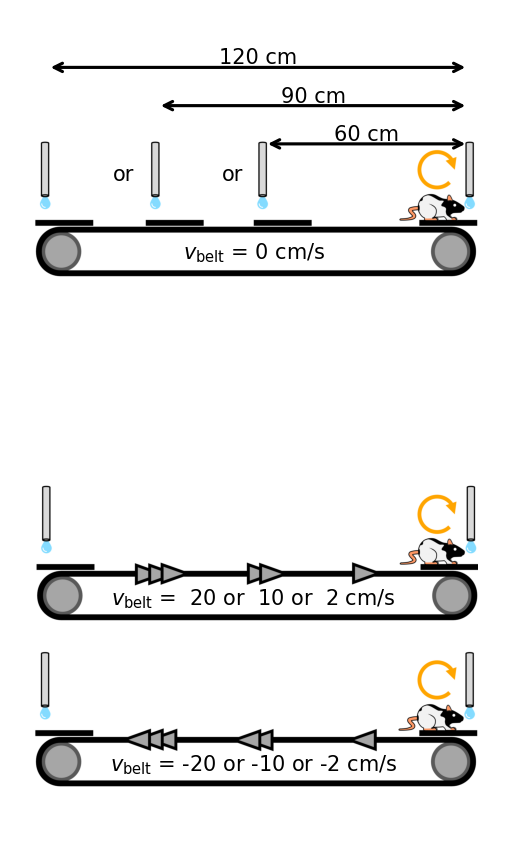

In [205]:
def Figure2E(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/2Didle.png"

    img = plt.imread(path)
    img = img[300:2000, 150:3075]
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{\mathrm{belt}}$ = 0 cm/s', x=img.shape[1]/2, y=1460, ha="center", va="center", fontsize=5)
    ax.text(s='or', x=610, y=950, ha="center", va="center", fontsize=5)
    ax.text(s='or', x=1325, y=950, ha="center", va="center", fontsize=5)

    ax.annotate(text='', xy=(1500, 750), xytext=(2900, 750), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='60 cm', xy=(0, 0), xytext=((1500+2900)/2, 750), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)
    ax.annotate(text='', xy=(800, 500), xytext=(2900, 500), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='90 cm', xy=(0, 0), xytext=((800+2900)/2, 500), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)
    ax.annotate(text='', xy=(80, 250), xytext=(2900, 250), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='120 cm', xy=(0, 0), xytext=((80+2900)/2, 250), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)

def Figure2J(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/2Eidle.png"

    img = plt.imread(path)
    img = img[:, 150:3075]
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{\mathrm{belt}}$ =  20 or  10 or  2 cm/s', x=img.shape[1]/2, y=930, ha="center", va="center", fontsize=5)
    ax.text(s=r'$v_{\mathrm{belt}}$ = -20 or -10 or -2 cm/s', x=img.shape[1]/2, y=2020, ha="center", va="center", fontsize=5)

fig, axs = plt.subplots(2, 1, figsize=(cm2inch(4), cm2inch(8)))
Figure2E(ax=axs[0])
Figure2J(ax=axs[1])

# Figure 4

/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: divide by zero encountered in true_divide
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))
/home/david/Desktop/code/VIGOR_MODELS_Functions.py:590: RuntimeWarning: invalid value encountered in multiply
  res = alpha / np.sqrt(arg) * np.exp(-((alpha-gamma * x) ** 2) / (2 * x))


Text(0.5, 0.5, '$\\gamma(t, R) = \\gamma_0 + \\gamma_t t + \\gamma_R R$')

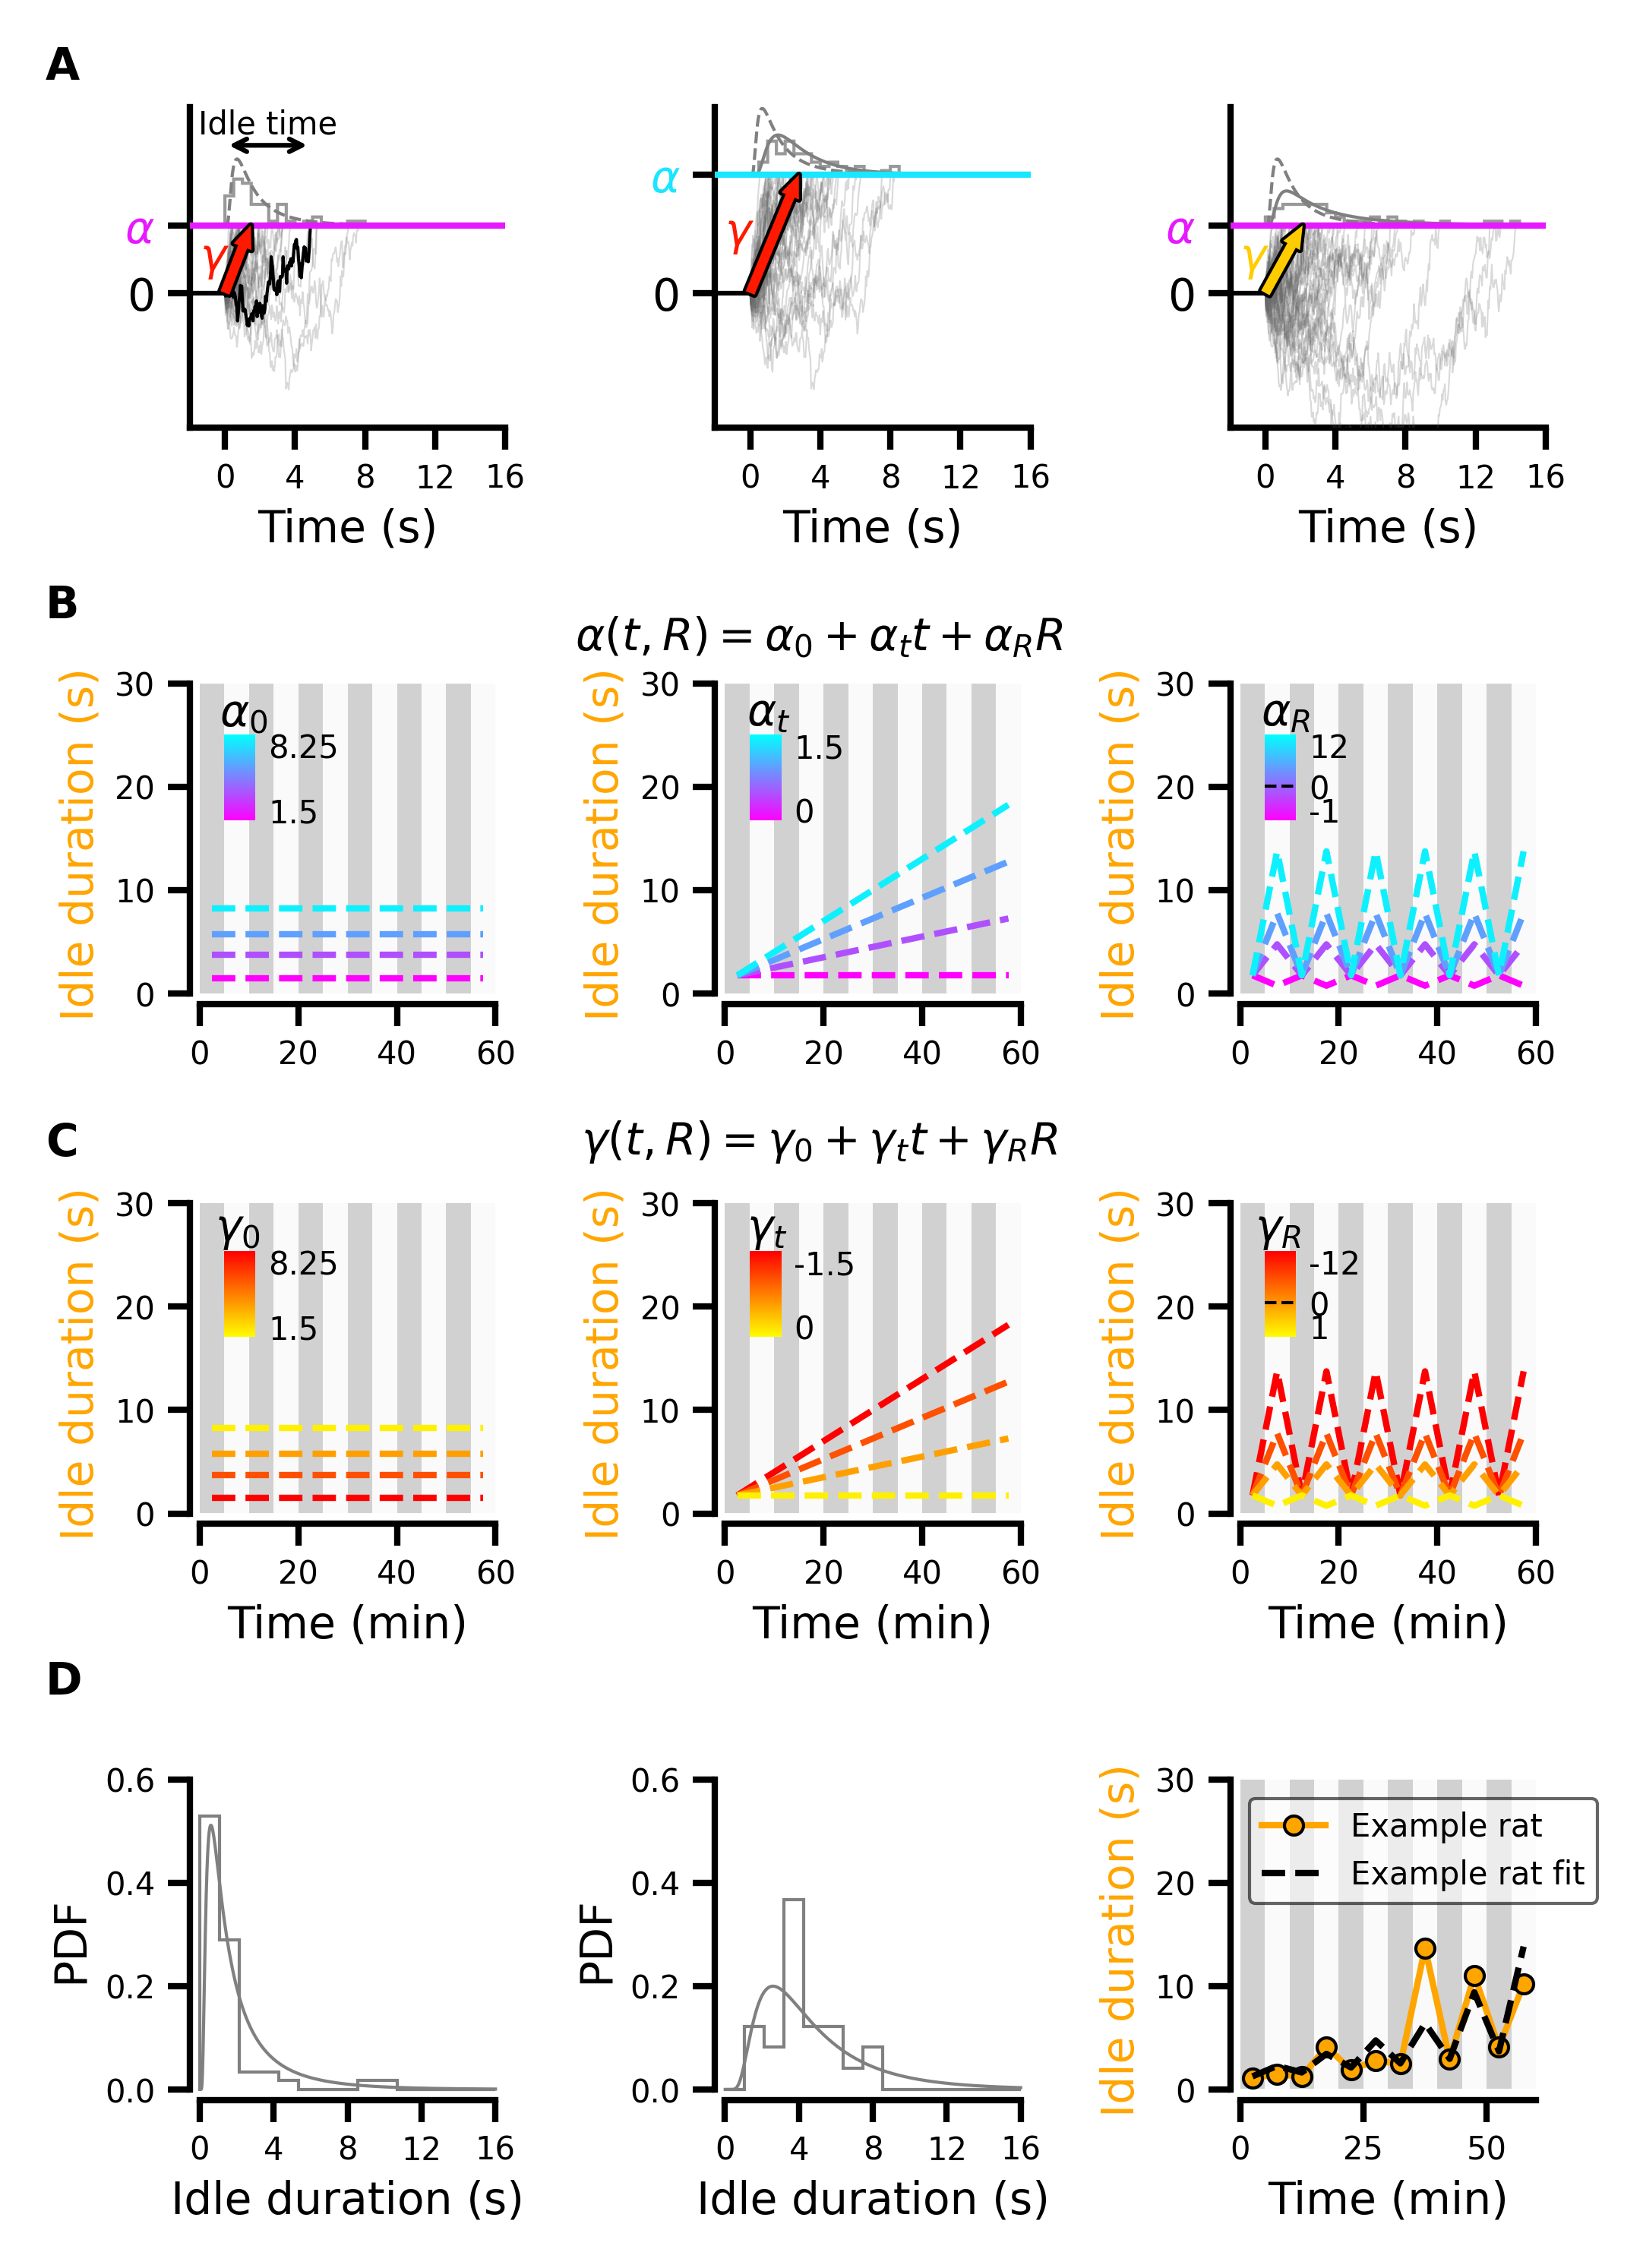

In [215]:

fig = plt.figure(figsize=(cm2inch(8.8), cm2inch(12)), 
                 constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(7, 3, height_ratios=[1, .1, 1, .1, 1, .1, 1], width_ratios=[1, 1, 1])

drift_diffusion_base = plt.subplot(gs0[0, 0])
drift_diffusion_1 = plt.subplot(gs0[0, 1])
drift_diffusion_2 = plt.subplot(gs0[0, 2])

explanation_alpha_0 = plt.subplot(gs0[2, 0])
explanation_alpha_t = plt.subplot(gs0[2, 1])
explanation_alpha_R = plt.subplot(gs0[2, 2])
explanation_gamma_0 = plt.subplot(gs0[4, 0])
explanation_gamma_t = plt.subplot(gs0[4, 1])
explanation_gamma_R = plt.subplot(gs0[4, 2])

fit_early = plt.subplot(gs0[6, 0])
fit_late = plt.subplot(gs0[6, 1])
modeldata = plt.subplot(gs0[6, 2])


x, y = Figure4_A(ax=drift_diffusion_base, A=8, mean=.2, base=True, 
                 alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.1))
Figure4_A(ax=drift_diffusion_1, A=14, mean=.2, base=False, 
          alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.1), xx=x, yy=y)
Figure4_A(ax=drift_diffusion_2, A=8, mean=.1, base=False, 
          alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.8), xx=x, yy=y)
# Figure4_A(ax=drift_diffusion_3, A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.8))


Figure4A(ax=explanation_alpha_0, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
Figure4B(ax=explanation_alpha_t, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
Figure4C(ax=explanation_alpha_R, cmap=plt.get_cmap("cool_r"), hide_xlabel=True)
Figure4A(ax=explanation_gamma_0)
Figure4B(ax=explanation_gamma_t, reverse=True)
Figure4C(ax=explanation_gamma_R, reverse=True)

plot_distribution_idle(fit_early, timebin=0, historybin=0)
plot_distribution_idle(fit_late, timebin=-1, historybin=0)
Figure4D(ax=modeldata)


h, w = 0.04, 0.02

cbarA = fig.add_axes([.123, .66, w, h])
plot_colorbar(ax=cbarA, label=r'$\alpha_0$', cmap="cool_r", labels=[1.5, 0, 8.25], y=1.5, labelpad=-15)

cbarB = fig.add_axes([.456, .66, w, h])
plot_colorbar(ax=cbarB, label=r'$\alpha_t$', cmap="cool_r", labels=[0, 0, 1.5], y=1.5, labelpad=-12)

cbarC = fig.add_axes([.782, .66, w, h])
plot_colorbar(ax=cbarC, label=r'$\alpha_R$', show_zero=160, cmap="cool_r", labels=[-1, 0, 12], y=1.5, labelpad=-10)


cbarA = fig.add_axes([.123, .42, w, h])
plot_colorbar(ax=cbarA, label=r'$\gamma_0$', cmap="autumn_r", labels=[1.5, 0, 8.25], y=1.5, labelpad=-16)

cbarB = fig.add_axes([.456, .42, w, h])
plot_colorbar(ax=cbarB, label=r'$\gamma_t$', cmap="autumn_r", labels=[0, 0, -1.5], y=1.5, labelpad=-14)

cbarC = fig.add_axes([.782, .42, w, h])
plot_colorbar(ax=cbarC, label=r'$\gamma_R$', cmap="autumn_r", show_zero=160, labels=[1, 0, -12], y=1.5, labelpad=-13)



figuresLabels={"A":[0.01, 1], "B":[0.01, .75], "C":[0.01, .50],  "D":[0.01, .25],}
for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

plt.text(s=r'$\alpha(t, R) = \alpha_0 + \alpha_t t + \alpha_R R$', 
         x=0.5, y=.735, ha="center", va="bottom", fontsize=7,
         transform=plt.gcf().transFigure)

plt.text(s=r'$\gamma(t, R) = \gamma_0 + \gamma_t t + \gamma_R R$', 
         x=0.5, y=.5, ha="center", va="bottom", fontsize=7,
         transform=plt.gcf().transFigure)

# plt.savefig("/home/david/Desktop/code/Figure_4_1.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

p_value_60_90: 0.8003 p_value_60_120: 0.8993 p_value_90_120: 0.661
p_value_60_90: 0.3405 p_value_60_120: 0.1241 p_value_90_120: 0.4785
p_value_60_90: 0.8739 p_value_60_120: 0.4437 p_value_90_120: 0.502
p_value_60_90: 0.9699 p_value_60_120: 0.849 p_value_90_120: 0.8349
p_value_60_90: 0.858 p_value_60_120: 0.6642 p_value_90_120: 0.5332
p_value_60_90: 0.9512 p_value_60_120: 0.9298 p_value_90_120: 0.8512
p_value_20_0: 0.8604 p_value_0_rev20: 0.8488 p_value_20_rev20: 0.7248
p_value_20_0: 0.3527 p_value_0_rev20: 0.166 p_value_20_rev20: 0.591
p_value_20_0: 0.7136 p_value_0_rev20: 0.9308 p_value_20_rev20: 0.7939
p_value_20_0: 0.5744 p_value_0_rev20: 0.2676 p_value_20_rev20: 0.0958
p_value_20_0: 0.9184 p_value_0_rev20: 0.0602 p_value_20_rev20: 0.0642
p_value_20_0: 0.8931 p_value_0_rev20: 0.7573 p_value_20_rev20: 0.6321


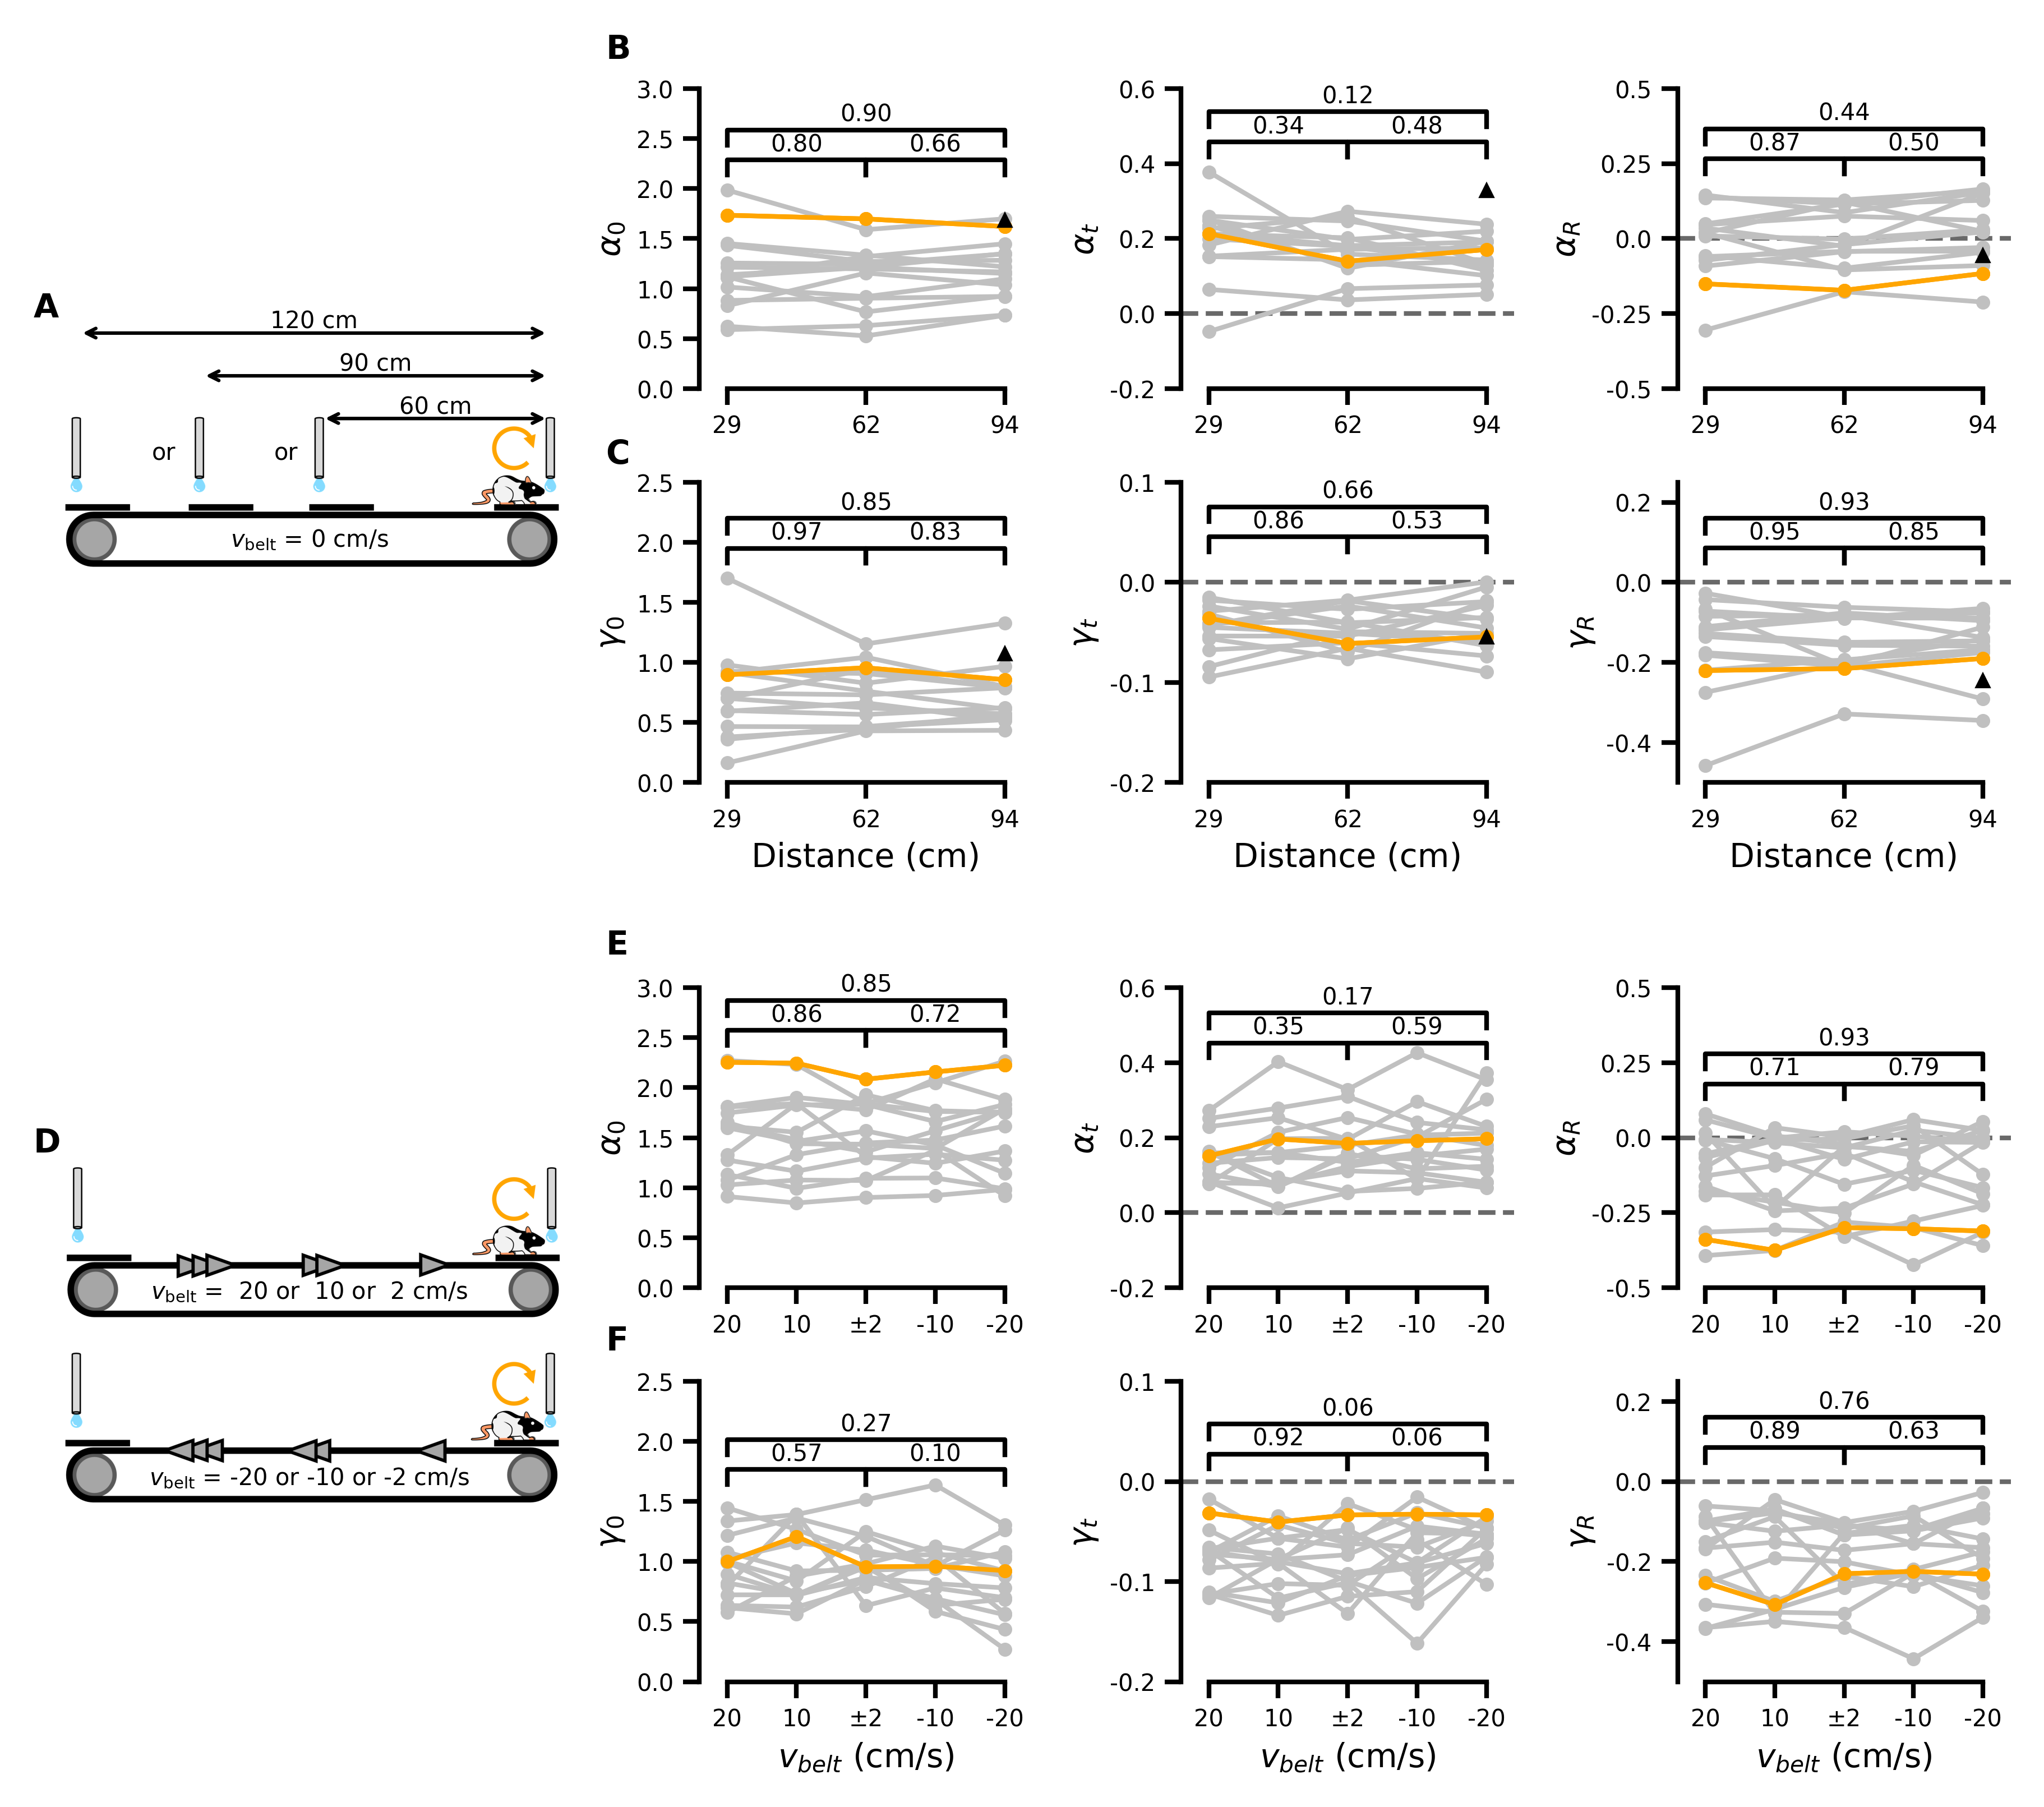

In [216]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(13)), 
                 constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 6, width_ratios=[.5, 1.5, 1, 1, 1, .5], height_ratios=[1, 1, .1, 1, 1])

distance_schematic = plt.subplot(gs0[0:2, 1])
fit_alpha_0_distance = plt.subplot(gs0[0, 2])
fit_alpha_t_distance = plt.subplot(gs0[0, 3])
fit_alpha_R_distance = plt.subplot(gs0[0, 4])

fit_gamma_0_distance = plt.subplot(gs0[1, 2])
fit_gamma_t_distance = plt.subplot(gs0[1, 3])
fit_gamma_R_distance = plt.subplot(gs0[1, 4])


vbelt_schematic = plt.subplot(gs0[3:5, 1])
fit_alpha_0_vbelt = plt.subplot(gs0[3, 2])
fit_alpha_t_vbelt = plt.subplot(gs0[3, 3])
fit_alpha_R_vbelt = plt.subplot(gs0[3, 4])

fit_gamma_0_vbelt = plt.subplot(gs0[4, 2])
fit_gamma_t_vbelt = plt.subplot(gs0[4, 3])
fit_gamma_R_vbelt = plt.subplot(gs0[4, 4])

Figure2E(ax=distance_schematic)
Figure2J(ax=vbelt_schematic)

Figure4F(ax=fit_alpha_0_distance)
Figure4G(ax=fit_alpha_t_distance)
Figure4H(ax=fit_alpha_R_distance)
Figure4I(ax=fit_gamma_0_distance, show_xlabel=True)
Figure4J(ax=fit_gamma_t_distance, show_xlabel=True)
Figure4K(ax=fit_gamma_R_distance, show_xlabel=True)

Figure4L(ax=fit_alpha_0_vbelt)
Figure4M(ax=fit_alpha_t_vbelt)
Figure4N(ax=fit_alpha_R_vbelt)
Figure4O(ax=fit_gamma_0_vbelt, show_xlabel=True)
Figure4P(ax=fit_gamma_t_vbelt, show_xlabel=True)
Figure4Q(ax=fit_gamma_R_vbelt, show_xlabel=True)


figuresLabels={"A":[0.08, .85], "B":[0.32, 1], "C":[0.32, .765], 
                "D":[0.08, .365], "E":[0.32, .48], "F":[0.32, .25],
               }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')


# plt.savefig("/home/david/Desktop/code/Figure_4_2.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

# suppl

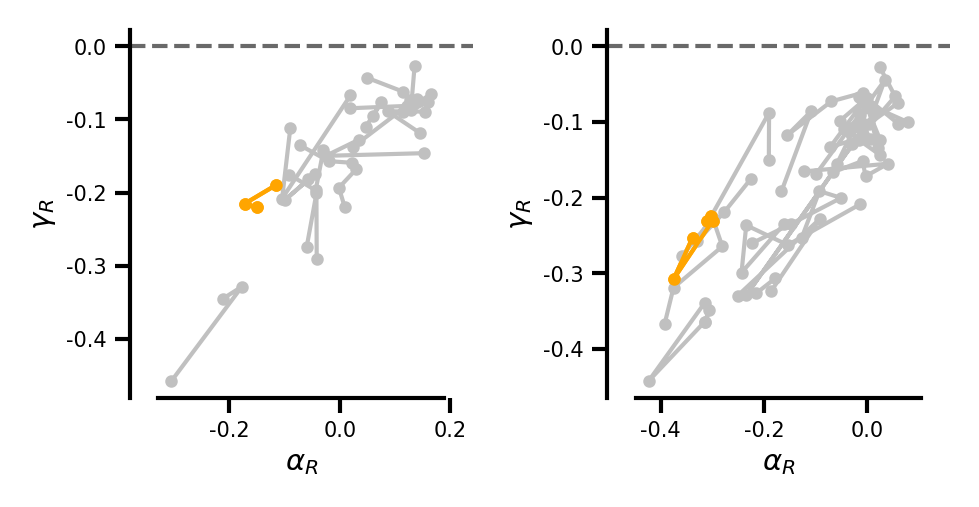

In [208]:
def Figure4_(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([alpha_R[animal]["60"], alpha_R[animal]["90"], alpha_R[animal]["120"]], [gamma_R[animal]["60"], gamma_R[animal]["90"], gamma_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([alpha_R[animal]["60"], alpha_R[animal]["90"], alpha_R[animal]["120"]],
                     [gamma_R[animal]["60"], gamma_R[animal]["90"], gamma_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    # ax.set_xlim(0, 4)
    # ax.set_xticks([0, 1, 2, 3, 4])
    # ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])

    ax.set_xlabel(r'$\alpha_R$')

    # ax.set_ylim(-0.5, 0.1)
    ax.set_ylabel(r'$\gamma_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

def Figure4__(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([alpha_R[animal]["rev20"], alpha_R[animal]["rev10"], alpha_R[animal]["2"], alpha_R[animal]["10"], alpha_R[animal]["20"]], [gamma_R[animal]["rev20"], gamma_R[animal]["rev10"], gamma_R[animal]["2"], gamma_R[animal]["10"], gamma_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([alpha_R[animal]["rev20"], alpha_R[animal]["rev10"], alpha_R[animal]["2"], alpha_R[animal]["10"], alpha_R[animal]["20"]],
                     [gamma_R[animal]["rev20"], gamma_R[animal]["rev10"], gamma_R[animal]["2"], gamma_R[animal]["10"], gamma_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    # ax.set_xlim(0, 4)
    # ax.set_xticks([0, 1, 2, 3, 4])
    # ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])

    ax.set_xlabel(r'$\alpha_R$')

    # ax.set_ylim(-0.5, 0.1)
    ax.set_ylabel(r'$\gamma_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)


fig, axs = plt.subplots(1, 2, figsize=(cm2inch(8), cm2inch(4)))
Figure4_(axs[0])
Figure4__(axs[1])